In [1]:
# importing relevant libraries and downloading necessary packages
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
df_labels = pd.read_csv('/content/drive/My Drive/CS 5112 Final Project/Code/latest data/hier_ward.csv', header=None)
#df_labels_kmeans = pd.read_csv('/content/drive/My Drive/CS 5112 Final Project/Code/latest data/kmeans_labels.csv', header=None)

In [5]:
df_og = pd.read_csv('/content/drive/My Drive/CS 5112 Final Project/Code/latest data/okcupid-cleaned-dropped-10k-handlabels.csv')
df_og.drop(df_og.tail(1).index,inplace=True)

In [6]:
df_og['job'].nunique()

20

In [7]:
df_og['cluster_labels'] = df_labels[0]

In [8]:
df_og['cluster_labels'].unique()

array([31., 27., 47.,  0.,  6., 29., 28., 12., 33., 49., 13., 32., 42.,
        4.,  7., 35., 15.,  2., 19.,  5., 23., 10., 24., 34., 46., 17.,
       22., 36., 11., 20.,  9.,  3., 21., 41.,  1., 25., 16., 18., 26.,
       30., 14., 37., 40., 39., 43., 45., 48.,  8., 38., 44.])

In [9]:
def get_compatible_groups(groups, sex, orientation, label):
  f_straight = groups[label][0]
  m_straight = groups[label][1]
  f_gay = groups[label][2]
  m_gay = groups[label][3]
  f_bisexual = groups[label][4]
  m_bisexual = groups[label][5]
  if sex == 'm' and orientation == 'straight':
    return np.append(f_straight, f_bisexual)
  elif sex == 'm' and orientation == 'gay':
    return np.append(m_gay, m_bisexual)
  elif sex == 'm' and orientation == 'bisexual':
    return np.append(m_gay, np.append(f_straight, np.append(m_bisexual, f_bisexual)))
  elif sex == 'f' and orientation == 'straight':
    return np.append(m_straight, m_bisexual)
  elif sex == 'f' and orientation == 'gay':
    return np.append(f_gay, f_bisexual)
  elif sex == 'f' and orientation == 'bisexual':
    return np.append(f_gay, np.append(m_straight, np.append(m_bisexual, f_bisexual)))
  else:
    return -1

In [10]:
def get_same_frac(groups, sex, orientation, label):
  cluster_size = groups[label][0]
  f_straight = groups[label][1]
  m_straight = groups[label][2]
  f_gay = groups[label][3]
  m_gay = groups[label][4]
  f_bisexual = groups[label][5]
  m_bisexual = groups[label][6]
  if sex == 'm' and orientation == 'straight':
    return m_straight/cluster_size
  elif sex == 'm' and orientation == 'gay':
    return m_gay/cluster_size
  elif sex == 'm' and orientation == 'bisexual':
    return m_bisexual/cluster_size
  elif sex == 'f' and orientation == 'straight':
    return f_straight/cluster_size
  elif sex == 'f' and orientation == 'gay':
    return f_gay/cluster_size
  elif sex == 'f' and orientation == 'bisexual':
    return f_bisexual/cluster_size
  else:
    return -1

In [11]:
pd.options.mode.chained_assignment = None  # default='warn'

def match(df):
  labels = df['cluster_labels'].unique()
  clusters_to_groups = {}
  frac_dict = {}
  for i in labels:
    df_filtered = df[df['cluster_labels'] == i]
    f_straight = df_filtered[((df_filtered['sex']=='f') & (df_filtered['orientation']=='straight'))].index.to_numpy()
    m_straight = df_filtered[((df_filtered['sex']=='m') & (df_filtered['orientation']=='straight'))].index.to_numpy()
    f_gay = df_filtered[((df_filtered['sex']=='f') & (df_filtered['orientation']=='gay'))].index.to_numpy()
    m_gay = df_filtered[((df_filtered['sex']=='m') & (df_filtered['orientation']=='gay'))].index.to_numpy()
    f_bisexual = df_filtered[((df_filtered['sex']=='f') & (df_filtered['orientation']=='bisexual'))].index.to_numpy()
    m_bisexual = df_filtered[((df_filtered['sex']=='m') & (df_filtered['orientation']=='bisexual'))].index.to_numpy()
    clusters_to_groups[i] = (f_straight, m_straight, f_gay, m_gay, f_bisexual, m_bisexual)
    frac_dict[i] = (df_filtered.shape[0], f_straight.size, m_straight.size, f_gay.size, m_gay.size, f_bisexual.size, m_bisexual.size)
  df['match'] = df.apply(lambda x: get_compatible_groups(clusters_to_groups, x['sex'], x['orientation'], x['cluster_labels']), axis=1)
  df['num_matches'] = df['match'].apply(lambda x: x.size)
  df['frac_same'] = df.apply(lambda x: get_same_frac(frac_dict, x['sex'], x['orientation'], x['cluster_labels']), axis=1)
  return df

In [12]:
df_match = match(df_og)

In [13]:
df_match['cluster_labels'].value_counts()

29.0    535
2.0     383
24.0    349
47.0    348
19.0    347
7.0     313
0.0     295
5.0     292
9.0     287
3.0     275
42.0    271
31.0    269
15.0    260
27.0    252
40.0    246
26.0    246
1.0     225
23.0    218
8.0     205
33.0    204
25.0    204
39.0    202
13.0    200
34.0    198
4.0     196
12.0    191
10.0    179
18.0    177
28.0    176
22.0    170
11.0    160
17.0    159
49.0    147
20.0    145
16.0    142
6.0     139
14.0    135
32.0    124
38.0    123
30.0    118
48.0    112
43.0    111
36.0    106
37.0     95
21.0     90
41.0     87
46.0     84
44.0     82
35.0     76
45.0     52
Name: cluster_labels, dtype: int64

In [14]:
df_match[df_match['cluster_labels'] == 5].frac_same.value_counts()

0.613014    179
0.273973     80
0.061644     18
0.013699      8
0.023973      7
Name: frac_same, dtype: int64

In [15]:
df_match['frac_same'].mean()

0.4303882577410245

In [23]:
df_match['num_matches'].min()

1

In [16]:
df_match['num_matches'].mean()
#df_match['num_matches'].std()

99.6541

Text(0, 0.5, 'Number of people')

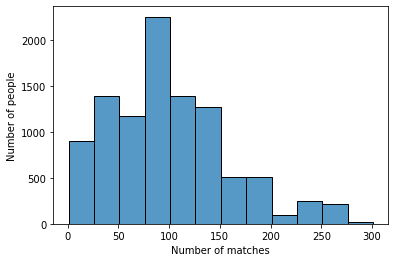

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=df_match, x="num_matches", binwidth=25)
plt.xlabel('Number of matches')
plt.ylabel('Number of people')

In [36]:
(df_match['num_matches'] > 200).sum()/10000

0.059

In [17]:
first = df_match.iloc[0]['match'].tolist()

In [18]:
df_match.iloc[0]['sex']

'f'

In [19]:
df_match.iloc[0]['orientation']

'straight'

In [73]:
df_match.iloc[0]['cluster_labels']

31.0

In [74]:
df_match.iloc[first, :]

,Unnamed: 0,age,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,job,sign,smokes,arabic,chinese,english,german,hindi,italian,japanese,korean,portuguese,russian,spanish,turkish,has kids,wants kids,likes dogs,likes cats,new_religion,hand-label,cluster_labels,match,num_matches,frac_same
67,46673.0,26.0,m,straight,3.0,anything,3.0,sometimes,graduated from college/university,mixed,76.0,other,whatever,no,no,no,yes,no,no,no,no,no,no,yes,yes,no,no,no,yes,yes,other,NaN,31.0,"[0, 30, 36, 63, 93, 156, 420, 468, 576, 699, 8...",86,0.583643
218,38798.0,23.0,m,straight,3.0,anything,2.0,sometimes,graduated from college/university,white,71.0,computer / hardware / software,whatever,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,yes,yes,agnosticism,NaN,31.0,"[0, 30, 36, 63, 93, 156, 420, 468, 576, 699, 8...",86,0.583643
287,16584.0,21.0,m,straight,6.0,anything,2.0,sometimes,graduated from college/university,white,71.0,artistic / musical / writer,whatever,no,no,no,yes,yes,no,no,no,no,no,no,no,no,no,no,yes,yes,none,NaN,31.0,"[0, 30, 36, 63, 93, 156, 420, 468, 576, 699, 8...",86,0.583643
403,44605.0,40.0,m,straight,3.0,vegetarian,2.0,sometimes,graduated from college/university,mixed,72.0,entertainment / media,whatever,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,yes,yes,yes,agnosticism,NaN,31.0,"[0, 30, 36, 63, 93, 156, 420, 468, 576, 699, 8...",86,0.583643
516,7238.0,23.0,m,straight,5.0,anything,2.0,sometimes,graduated from college/university,white,72.0,entertainment / media,does_not_matter,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,yes,yes,atheism,NaN,31.0,"[0, 30, 36, 63, 93, 156, 420, 468, 576, 699, 8...",86,0.583643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6483,24847.0,36.0,m,bisexual,6.0,other,2.0,sometimes,graduated from college/university,mixed,70.0,transportation,whatever,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,yes,yes,buddhism,NaN,31.0,"[1130, 2013, 3054, 3436, 7085, 7605, 8160, 912...",106,0.037175
7148,36607.0,28.0,m,bisexual,3.0,anything,2.0,sometimes,graduated from college/university,white,67.0,science / tech / engineering,does_not_matter,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,yes,yes,no,none,NaN,31.0,"[1130, 2013, 3054, 3436, 7085, 7605, 8160, 912...",106,0.037175
8048,59042.0,33.0,m,bisexual,5.0,anything,4.0,sometimes,graduated from college/university,white,70.0,artistic / musical / writer,does_not_matter,no,no,no,yes,no,no,yes,no,no,no,no,no,no,no,no,yes,yes,atheism,NaN,31.0,"[1130, 2013, 3054, 3436, 7085, 7605, 8160, 912...",106,0.037175
8828,12183.0,27.0,m,bisexual,3.0,anything,2.0,sometimes,graduated from college/university,white,68.0,computer / hardware / software,does_not_matter,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,yes,yes,atheism,NaN,31.0,"[1130, 2013, 3054, 3436, 7085, 7605, 8160, 912...",106,0.037175
